## Working with feature geometries

To read the features from a feature collection (e.g a gpml or shapefile) from a file into memory, you need to use the following lines:

In [18]:
import pygplates
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

input_feature_filename = "Data/LIPs_2014.gpmlz"

features = pygplates.FeatureCollection(input_feature_filename)


The 'features' object contains all the features in that file - for example, every isochron in an isochron file. 

A simple way to to access individual features is to iterate over the features in a “for” loop. 

Each feature has properties (the ones you would see if you clicked on that feature in gplates) and a geometry (the point/line/polygon that gplates displays). We can access these for each feature, here is an example where for each feature within a feature collection, we print the Plate ID.

In [19]:
ids=set()
print('There are {0} features in the file {1}.'.format(len(features),input_feature_filename))

for feature in features:
    ids.add(feature.get_reconstruction_plate_id())
    
print('The {0} features have {1} unique plate ids.'.format(len(features), len(ids)))
print('The unique plate ids are {}.'.format(list(ids)))

There are 92 features in the file Data/LIPs_2014.gpmlz.
The 92 features have 21 unique plate ids.
The unique plate ids are [901, 909, 911, 801, 802, 293, 301, 690, 701, 702, 704, 201, 714, 973, 982, 983, 101, 750, 111, 501, 511].


We can iterate over the features and look at the geometry type for each one

In [20]:
polygons=[]
points=[]
polylines=[]
for feature in features:
    geom = feature.get_geometry()
    if isinstance(geom, pygplates.PointOnSphere):
        points.append(geom)
    if isinstance(geom, pygplates.PolylineOnSphere):
        polylines.append(geom)
    if isinstance(geom, pygplates.PolygonOnSphere):
        polygons.append(geom)
print('The number of point geometries is {}.'.format(len(points)))
print('The number of polyline geometries is {}.'.format(len(polylines)))
print('The number of polygon geometries is {}.'.format(len(polygons)))

The number of point geometries is 0.
The number of polyline geometries is 0.
The number of polygon geometries is 92.


This code combines both property and geometry capabilities.

It says, 'find me the features where the plate ID is 901, and show me the area of each polygon that have this plate ID'.


In [21]:
areas=[]
for feature in features:
    if feature.get_reconstruction_plate_id() == 901:
        areas.append(feature.get_geometry().get_area())
print('There are {} features of which the plate id is 901.'.format(len(areas)))
print('The areas of these features are {}.'.format(areas))
print('(NB the area is expressed for a unit sphere - to convert to Earth units, need to multiply by radius**2)')

There are 10 features of which the plate id is 901.
The areas of these features are [0.008462390804901077, 0.0029243367850391166, 0.000537599895546137, 0.005490039632407573, 7.470057263114782e-05, 5.425200111552897e-05, 0.0002357091250955179, 0.008819388784964577, 0.046452183556873194, 0.012645968005752906].
(NB the area is expressed for a unit sphere - to convert to Earth units, need to multiply by radius**2)


Since we are often interested in having the point coordinates as latitudes and longitudes, there are a number of methods to give these to us.

For example, the following shows how to iterate over the polygons in a feature collection and, for polygons with plateid=101,

    - get the centroid point of the polygon
    - get the latitude and longitude of each centroid point

In [22]:
centroids=[]
for feature in features:
    if feature.get_reconstruction_plate_id() == 101:
        polygon = feature.get_geometry()
        centroids.append(polygon.get_boundary_centroid().to_lat_lon())
        
print('There are {} polygon features with the plate id 101.'.format(len(centroids)))
print('The centroids are {}.'.format(centroids))


There are 3 polygon features with the plate id 101.
The centroids are [(32.32261854767031, -64.79063765137695), (34.40311102132128, -76.23081963225276), (37.12233943627294, -59.74171706937214)].


To access the individual vertices of polygons, you can use this code:

Showing 13 polygons.


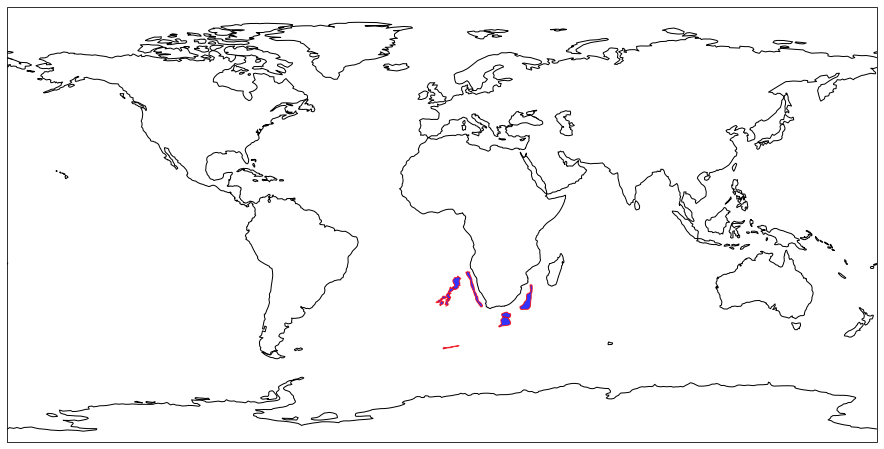

In [23]:
polygons=[]
for feature in features:
    if feature.get_reconstruction_plate_id() == 701:
        polygon = feature.get_geometry()
        #get Polygon vertices and construct shapely polygon object
        polygons.append(Polygon(((lon,lat) for lat, lon in polygon.to_lat_lon_list())))
        
plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_geometries(polygons, crs=ccrs. PlateCarree(), facecolor='b', edgecolor='red', alpha=0.8)
print('Showing {} polygons.'.format(len(polygons)))
plt.show()

The following example shows how to reconstruct individual feature geometries using a rotation pole derived from a rotation file. This gives more fine-grained control on reconstructions than the basic 'pygplates.reconstruct' function, which is suitable for reconstructing all the features in a collection for a single reconstruction time. 

Here, we iterate over a series of feature geometries, determine a 'rotation' object based on the attributes of that polygon, and apply this rotation to the centroid point geometry using:

             rotation * polygon.get_boundary_centroid()

The finite rotation is (rot = (pole = (lat: 34.104, lon: -54.5802) (which is antipodal to (lat: -34.104, lon: 125.42)); angle = -10.6035 deg)).
The original centroids are in red.
The reconstructed centroids are in blue.


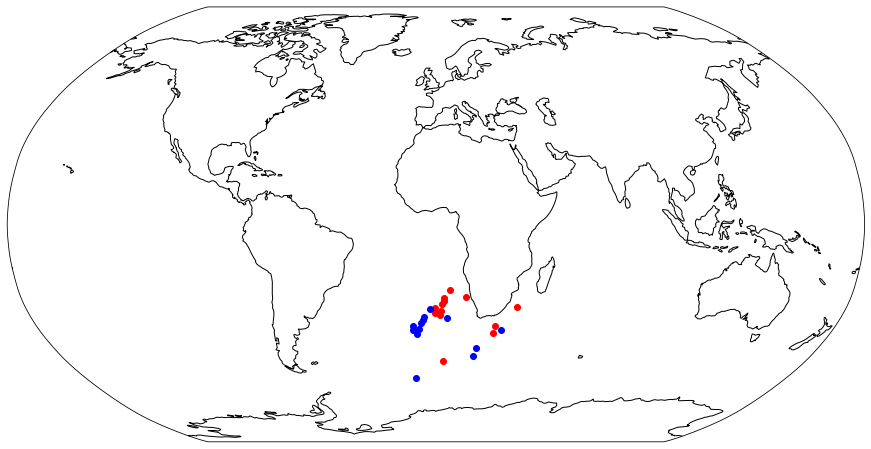

In [24]:
# Load a rotation file
input_rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'

rotation_model=pygplates.RotationModel(input_rotation_filename)

# Get finite rotation for plate 701 relative to spin axis at 52 Ma
rotation = rotation_model.get_rotation(52.,701, 0., 1)
print('The finite rotation is {}.'.format(rotation))

# For each LIP polygon feature with plateid 701, get the centroid location and reconstruct it 
# based on the rotation pole we just got from the rotation file
centroids = []
reconstructed_centroids = []
for feature in features:
    if feature.get_reconstruction_plate_id() == 701:
        polygon = feature.get_geometry()
        centroid = polygon.get_boundary_centroid()
        centroids.append(centroid.to_lat_lon())
        reconstructed_centroid = rotation * centroid
        reconstructed_centroids.append(reconstructed_centroid.to_lat_lon())
        
plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()

print('The original centroids are in red.')
print('The reconstructed centroids are in blue.')

[lat,lon] = zip(*centroids)
ax.scatter(lon,lat, color='red', transform=ccrs.PlateCarree())
[lat,lon] = zip(*reconstructed_centroids)
ax.scatter(lon,lat, color='blue', transform=ccrs.PlateCarree())

plt.show()
        